## Import

In [1317]:
import sys
sys.path.append('..')


In [1318]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report


## 1. Data Analysis

Display first 10 rows

In [1319]:
df = pd.read_csv('../datasets/people/aw_fb_data.csv')

df.head(10)


,Unnamed: 0,X1,age,gender,height,weight,steps,hear_rate,calories,distance,entropy_heart,entropy_setps,resting_heart,corr_heart_steps,norm_heart,intensity_karvonen,sd_norm_heart,steps_times_distance,device,activity
0,1,1,20,1,168.0,65.4,10.771429,78.531302,0.344533,0.008327,6.221612,6.116349,59.0,1.000000,19.531302,0.138520,1.000000,0.089692,apple watch,Lying
1,2,2,20,1,168.0,65.4,11.475325,78.453390,3.287625,0.008896,6.221612,6.116349,59.0,1.000000,19.453390,0.137967,1.000000,0.102088,apple watch,Lying
2,3,3,20,1,168.0,65.4,12.179221,78.540825,9.484000,0.009466,6.221612,6.116349,59.0,1.000000,19.540825,0.138587,1.000000,0.115287,apple watch,Lying
3,4,4,20,1,168.0,65.4,12.883117,78.628260,10.154556,0.010035,6.221612,6.116349,59.0,1.000000,19.628260,0.139208,1.000000,0.129286,apple watch,Lying
4,5,5,20,1,168.0,65.4,13.587013,78.715695,10.825111,0.010605,6.221612,6.116349,59.0,0.982816,19.715695,0.139828,0.241567,0.144088,apple watch,Lying
5,6,6,20,1,168.0,65.4,14.290909,78.803129,11.495667,0.011174,6.221612,6.116349,59.0,1.000000,19.803129,0.140448,0.264722,0.159691,apple watch,Sitting
6,7,7,20,1,168.0,65.4,14.994805,78.890564,12.166222,0.011744,6.221612,6.116349,59.0,1.000000,19.890564,0.141068,0.264722,0.176096,apple watch,Sitting
7,8,8,20,1,168.0,65.4,15.698701,78.977999,12.836778,0.012313,6.221612,6.116349,59.0,1.000000,19.977999,0.141688,0.264722,0.193303,apple watch,Sitting
8,9,9,20,1,168.0,65.4,16.402597,79.065434,13.507333,0.012883,6.221612,6.116349,59.0,1.000000,20.065434,0.142308,0.264722,0.211311,apple watch,Sitting
9,10,10,20,1,168.0,65.4,17.106494,79.152869,14.177889,0.013452,6.221612,6.116349,59.0,1.000000,20.152869,0.142928,0.264722,0.230121,apple watch,Sitting


In [1320]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6264 entries, 0 to 6263
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            6264 non-null   int64  
 1   X1                    6264 non-null   int64  
 2   age                   6264 non-null   int64  
 3   gender                6264 non-null   int64  
 4   height                6264 non-null   float64
 5   weight                6264 non-null   float64
 6   steps                 6264 non-null   float64
 7   hear_rate             6264 non-null   float64
 8   calories              6264 non-null   float64
 9   distance              6264 non-null   float64
 10  entropy_heart         6264 non-null   float64
 11  entropy_setps         6264 non-null   float64
 12  resting_heart         6264 non-null   float64
 13  corr_heart_steps      6264 non-null   float64
 14  norm_heart            6264 non-null   float64
 15  intensity_karvonen   

In [1321]:
df.describe()


,Unnamed: 0,X1,age,gender,height,weight,steps,hear_rate,calories,distance,entropy_heart,entropy_setps,resting_heart,corr_heart_steps,norm_heart,intensity_karvonen,sd_norm_heart,steps_times_distance
count,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000
mean,3132.500000,1771.144317,29.158525,0.476533,169.709052,69.614464,109.562268,86.142331,19.471823,13.832555,6.030314,5.739984,65.869938,0.306447,20.272393,0.155479,8.110854,590.035239
std,1808.405375,1097.988748,8.908978,0.499489,10.324698,13.451878,222.797908,28.648385,27.309765,45.941437,0.765574,1.256348,21.203017,0.775418,28.388116,0.210927,12.535080,4063.838530
min,1.000000,1.000000,18.000000,0.000000,143.000000,43.000000,1.000000,2.222222,0.056269,0.000440,0.000000,0.000000,3.000000,-1.000000,-76.000000,-2.714286,0.000000,0.000690
25%,1566.750000,789.750000,23.000000,0.000000,160.000000,60.000000,5.159534,75.598079,0.735875,0.019135,6.108524,5.909440,58.134333,-0.467303,1.148883,0.009819,0.264722,0.659260
50%,3132.500000,1720.000000,28.000000,0.000000,168.000000,68.000000,10.092029,77.267680,4.000000,0.181719,6.189825,6.157197,75.000000,0.665829,9.820254,0.079529,2.893503,13.368619
75%,4698.250000,2759.250000,33.000000,1.000000,180.000000,77.300000,105.847222,95.669118,20.500000,15.697188,6.247928,6.247928,76.138701,1.000000,27.077336,0.211868,9.679672,93.728562
max,6264.000000,3670.000000,56.000000,1.000000,191.000000,115.000000,1714.000000,194.333333,97.500000,335.000000,6.475733,6.475733,155.000000,1.000000,156.319444,1.297980,74.457929,51520.000000


In [1322]:
df.shape


(6264, 20)

In [1323]:
df['activity'].unique()


array(['Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs'], dtype=object)

According to result above, we can see that there are 7 differet activities of the users.

### Count total number of each activity

In [1324]:
df.activity.value_counts()


Lying             1379
Running 7 METs    1114
Running 5 METs    1002
Running 3 METs     950
Sitting            930
Self Pace walk     889
Name: activity, dtype: int64

In [1325]:
df.dtypes.value_counts()


float64    14
int64       4
object      2
dtype: int64

### Plot object type data

<AxesSubplot:ylabel='device'>

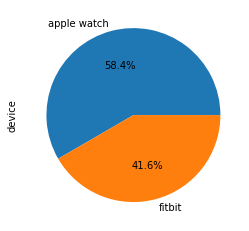

In [1326]:
df['device'].value_counts().plot.pie(autopct='%1.1f%%')


<AxesSubplot:ylabel='activity'>

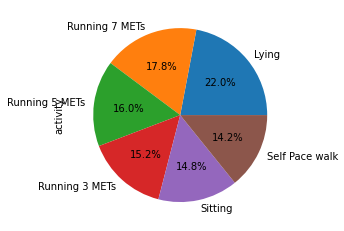

In [1327]:
df['activity'].value_counts().plot.pie(autopct='%1.1f%%')


### Plot activities of each device on heatmap

<AxesSubplot:xlabel='device', ylabel='activity'>

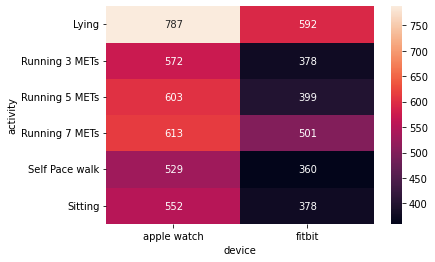

In [1328]:
sns.heatmap(pd.crosstab(df["activity"], df["device"]), annot=True, fmt='d')


## 2. Data Preprocessing

Prepare df for prediction

In [1329]:
df = df[["steps", "calories", "entropy_heart", "entropy_setps",
         "corr_heart_steps", "intensity_karvonen", "sd_norm_heart", "device", "activity"]]


In [1330]:
df.isna().sum()


steps                 0
calories              0
entropy_heart         0
entropy_setps         0
corr_heart_steps      0
intensity_karvonen    0
sd_norm_heart         0
device                0
activity              0
dtype: int64

### Find outlier

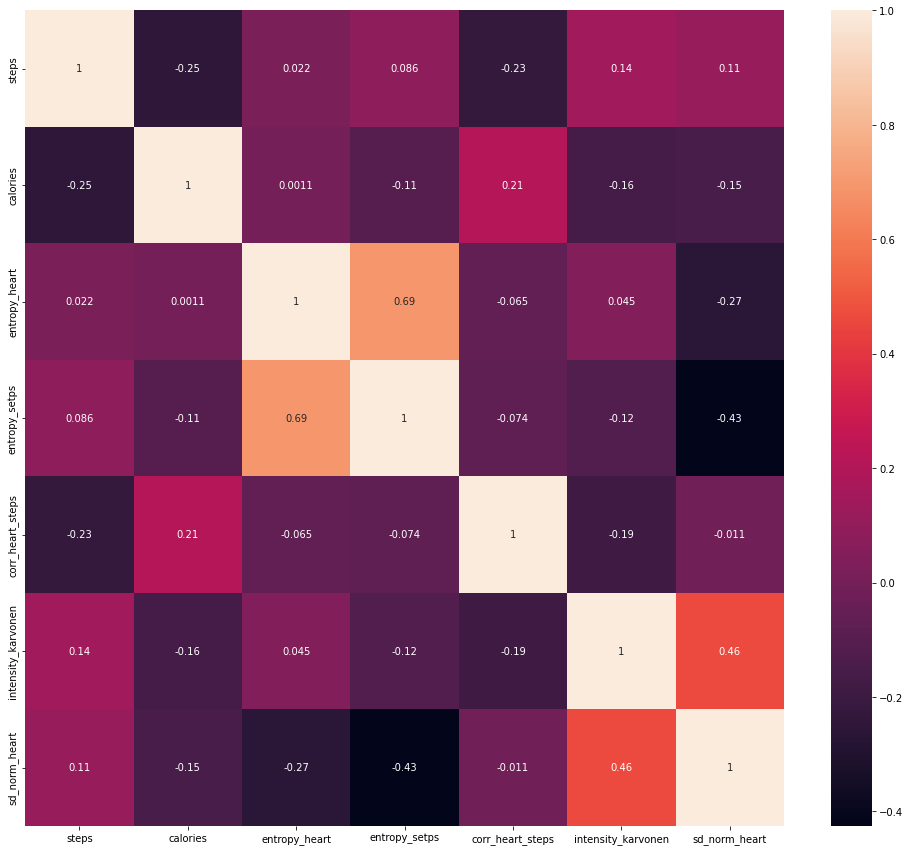

In [1331]:
ax = plt.subplots(figsize=(17, 15))
ax = sns.heatmap(df.corr(), annot=True)


In [1332]:
# remove outlier using interquartile range (IQR)
def outlier_limits(col):
    Q3, Q1 = np.nanpercentile(col, [75, 25])
    IQR = Q3 - Q1
    UL = Q3 + 1.5*IQR
    LL = Q1 - 1.5*IQR
    return UL, LL


In [1333]:
for column in df.columns:
    if df[column].dtype != 'object':
        UL, LL = outlier_limits(df[column])
        df[column] = np.where((df[column] > UL) | (
            df[column] < LL), np.nan, df[column])


In [1334]:
df.isna().sum()


steps                  814
calories              1149
entropy_heart          639
entropy_setps          641
corr_heart_steps         0
intensity_karvonen     520
sd_norm_heart          636
device                   0
activity                 0
dtype: int64

Drop outlier

In [1335]:
df.dropna()


,steps,calories,entropy_heart,entropy_setps,corr_heart_steps,intensity_karvonen,sd_norm_heart,device,activity
0,10.771429,0.344533,6.221612,6.116349,1.000000,0.138520,1.000000,apple watch,Lying
1,11.475325,3.287625,6.221612,6.116349,1.000000,0.137967,1.000000,apple watch,Lying
2,12.179221,9.484000,6.221612,6.116349,1.000000,0.138587,1.000000,apple watch,Lying
3,12.883117,10.154556,6.221612,6.116349,1.000000,0.139208,1.000000,apple watch,Lying
4,13.587013,10.825111,6.221612,6.116349,0.982816,0.139828,0.241567,apple watch,Lying
...,...,...,...,...,...,...,...,...,...
6185,2.223684,26.500000,6.339850,6.339850,1.000000,0.001021,0.066959,fitbit,Running 7 METs
6186,2.105263,28.000000,6.339850,6.339850,1.000000,0.000817,0.066959,fitbit,Running 7 METs
6187,1.986842,26.500000,6.339850,6.339850,1.000000,0.000613,0.066959,fitbit,Running 7 METs
6188,1.868421,26.500000,6.339850,6.339850,1.000000,0.000408,0.066959,fitbit,Running 7 METs


In [1336]:
df = df.dropna(axis=0)


In [1337]:
# Subdivision du dataset en deux (apple watch et fitbit)
df_apple = df.loc[df["device"] == "apple watch"]
df_fitbit = df.loc[df["device"] == "fitbit"]

df_apple = df_apple.drop("device", axis=1)
df_fitbit = df_fitbit.drop("device", axis=1)


## 3. Training

Split Apple & Fitbit data

In [1338]:
# df_apple = df.loc[df["device"] == "apple watch"]
# df_fitbit = df.loc[df["device"] == "fitbit"]


In [1339]:
df_apple


,steps,calories,entropy_heart,entropy_setps,corr_heart_steps,intensity_karvonen,sd_norm_heart,activity
0,10.771429,0.344533,6.221612,6.116349,1.000000,0.138520,1.000000,Lying
1,11.475325,3.287625,6.221612,6.116349,1.000000,0.137967,1.000000,Lying
2,12.179221,9.484000,6.221612,6.116349,1.000000,0.138587,1.000000,Lying
3,12.883117,10.154556,6.221612,6.116349,1.000000,0.139208,1.000000,Lying
4,13.587013,10.825111,6.221612,6.116349,0.982816,0.139828,0.241567,Lying
...,...,...,...,...,...,...,...,...
3620,90.000000,0.756000,6.162427,5.655310,0.682364,0.348133,2.931990,Running 3 METs
3621,119.000000,0.756000,6.162427,5.655310,0.801849,0.358372,2.931990,Running 3 METs
3622,64.000000,0.758000,6.162427,5.655310,0.882916,0.368611,2.931990,Running 3 METs
3623,179.250000,0.459333,6.162427,5.655310,0.937173,0.378850,2.931990,Lying


In [1340]:
X = df_apple.drop("activity", axis=1)
y = df_apple.loc[:, "activity"]


In [1341]:
X = df_fitbit.drop("activity", axis=1)
y = df_fitbit.loc[:, "activity"]


Ordinal encoding

In [1342]:
df_apple['activity'].unique()


array(['Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs'], dtype=object)

In [1343]:
df_fitbit['activity'].unique()


array(['Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs'], dtype=object)

In [1344]:
def one_hot_encoding(df):
    ordinal_encoder = ce.OrdinalEncoder(cols=['activity'],
                                        mapping=[
        {'col': 'activity', 'mapping': {
            'Lying': 0, 'Self Pace walk': 1, 'Running 3 METs': 2, 'Running 5 METs': 3, 'Sitting': 4, 'Running 7 METs': 5}},
    ])

    df_ = ordinal_encoder.fit_transform(df)
    return df


In [1345]:
def preprocessing(df):
    df = one_hot_encoding(df)
    X = df.drop("activity", axis=1)
    y = df.loc[:, "activity"]
    print(y.value_counts())
    return X, y


In [1346]:
Apple_trainset, Apple_testset = train_test_split(df_apple, test_size=0.2)
fitbit_trainset, fitbit_testset = train_test_split(df_fitbit, test_size=0.2)


In [1347]:
XApple_train, yApple_train = preprocessing(Apple_trainset)


Lying             417
Running 3 METs    360
Self Pace walk    317
Running 5 METs    316
Sitting           253
Running 7 METs    162
Name: activity, dtype: int64


In [1348]:
Xfitbit_train, yfitbit_train = preprocessing(fitbit_trainset)


Lying             295
Sitting           175
Running 7 METs    161
Running 3 METs     58
Self Pace walk     52
Running 5 METs     43
Name: activity, dtype: int64


In [1349]:
Xfitbit_test, yfitbit_test = preprocessing(fitbit_testset)


Lying             72
Sitting           63
Running 7 METs    31
Running 5 METs    13
Self Pace walk    12
Running 3 METs     6
Name: activity, dtype: int64


In [1350]:
XApple_test, yApple_test = preprocessing(Apple_testset)


Lying             110
Running 3 METs     92
Running 5 METs     86
Self Pace walk     83
Sitting            56
Running 7 METs     30
Name: activity, dtype: int64


In [1351]:
def standardisation(df):
    scaler = StandardScaler()
    X = scaler.fit_transform(df)
    return X


XApple_train = standardisation(XApple_train)
Xfitbit_test = standardisation(Xfitbit_test)
XApple_test = standardisation(XApple_test)
Xfitbit_train = standardisation(Xfitbit_train)


## 4. Evaluation

In [1352]:
KNN = KNeighborsClassifier()
SVM = SVC()


In [1353]:
def evaluation(model, Xtrain, Ytrain, Xtest, Ytest):
    model.fit(Xtrain, Ytrain)
    ypred = KNN.predict(Xtest)
    print(confusion_matrix(Ytest, ypred))
    print(classification_report(Ytest, ypred))
    print("Train {}".format(
        model.score(Xtrain, Ytrain)))
    print("Test {}".format(
        model.score(Xtest, Ytest)))


In [1354]:
print("evaluation sur apple watch")
evaluation(KNN, XApple_train, yApple_train, XApple_test, yApple_test)


evaluation sur apple watch
[[76 13  3  5  5  8]
 [14 61  5  1  7  4]
 [ 8  0 65  4  6  3]
 [ 1  1  3 23  0  2]
 [ 5  6  3  0 67  2]
 [10  3  4  4  6 29]]
                precision    recall  f1-score   support

         Lying       0.67      0.69      0.68       110
Running 3 METs       0.73      0.66      0.69        92
Running 5 METs       0.78      0.76      0.77        86
Running 7 METs       0.62      0.77      0.69        30
Self Pace walk       0.74      0.81      0.77        83
       Sitting       0.60      0.52      0.56        56

      accuracy                           0.70       457
     macro avg       0.69      0.70      0.69       457
  weighted avg       0.70      0.70      0.70       457

Train 0.8252054794520548
Test 0.7024070021881839


/Users/vatanak/Library/Python/3.8/lib/python/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/vatanak/Library/Python/3.8/lib/python/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 